# 🏋️ Model Training - Negative Sampled

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics
from lib.model.inference import ensemble_inference

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=4,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=7,
          negative_sample=True,
          negative_sample_partitions=3,
          oversample=False,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          print_freq=6,
          random_seed=20,
          scheduler='cosine',
          stride=192,
          tokenizer_version=2,
          train=True,
          train_folds=[0, 1, 2, 3, 4, 5, 6, 7],
          weight_decay=0.01)


In [5]:
seed_everything()

In [6]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


### Setting Up WandB

In [7]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = config.model.split("/")[-1]
WANDB_NAME = f"{model_name}-{config.max_length}-D{config.data_version}-T{config.tokenizer_version}"

In [8]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## 📖 Definitions

### 🌎 Global Variables

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [10]:
# class_weights = torch.tensor([1.0, 0.25, 0.25, 0.5, 1.0, 2.0]).to(device)
class_weights = torch.tensor([1.0] * 6).to(device)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(Paths.TOKENIZER_PATH)
vocabulary = tokenizer.get_vocab()
total_tokens = len(vocabulary)
print("Total number of tokens in the tokenizer:", total_tokens)
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of tokens in the tokenizer: 128003
DebertaV2TokenizerFast(name_or_path='output/microsoft/deberta-v3-xsmall/tokenizer_v2', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized

### 🛠️ Functions

In [12]:
def train_loop(fold, group, valid_labels):
    print(f"========== Fold: {fold} Group: {group} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold, group)

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(
        train_loader, device
    )

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            fold, valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        wandb.log(
            {
                f"eval/eval_epoch_f{fold}_g{group}": epoch + 1,
                f"eval/eval_loss_f{fold}_g{group}": avg_val_loss,
                f"eval/qwk_score_f{fold}_g{group}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - "
            + f"avg_train_loss: {avg_loss:.4f} "
            + f"avg_val_loss: {avg_val_loss:.4f} "
            + f"time: {elapsed:.0f}s "
            + f"Score: {score:.4f}"
        )

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict()},
                Paths.MODEL_OUTPUT_PATH
                + f"/{config.model.replace('/', '_')}_fold_{fold}_group_{group}.pth",
            )

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

In [13]:
def evaluate_group(fold, valid_fold, valid_labels, model_paths):
    predictions = ensemble_inference(
        valid_fold,
        tokenizer,
        model_paths,
        device,
        overall=False,
    )
    score = get_score(valid_labels, predictions)

    wandb.log(
        {
            f"eval/eval_epoch_f{fold}": config.epochs,
            f"eval/qwk_score_f{fold}": score,
        }
    )
    return predictions

In [14]:
def train_all_groups(fold):
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values
    model_paths = {
        os.path.join(
            Paths.MODEL_OUTPUT_PATH,
            f"{config.model.replace('/', '_')}_fold_{fold}_group_{group}.pth",
        ): 1
        for group in range(config.negative_sample_partitions)
    }

    for group in range(config.negative_sample_partitions):
        train_loop(fold, group, valid_labels)

    valid_fold["pred_score"] = evaluate_group(
        fold,
        valid_fold,
        valid_labels,
        model_paths,
    )
    return valid_fold

In [15]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [16]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_all_groups(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 Group: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 155/155 [00:26<00:00,  5.80valid_batch/s]


Epoch 1 - avg_train_loss: 1.4597 avg_val_loss: 1.2897 time: 117s Score: 0.6150
Epoch 1 - Save Best Score: 0.6150 Model


Validating Fold 0: 100%|██████████| 155/155 [00:27<00:00,  5.73valid_batch/s]


Epoch 2 - avg_train_loss: 1.1088 avg_val_loss: 1.0576 time: 121s Score: 0.6966
Epoch 2 - Save Best Score: 0.6966 Model
========== Fold: 0 Group: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 155/155 [00:26<00:00,  5.77valid_batch/s]


Epoch 1 - avg_train_loss: 1.4444 avg_val_loss: 1.1477 time: 123s Score: 0.6537
Epoch 1 - Save Best Score: 0.6537 Model


Validating Fold 0: 100%|██████████| 155/155 [00:27<00:00,  5.72valid_batch/s]


Epoch 2 - avg_train_loss: 1.0816 avg_val_loss: 1.1271 time: 123s Score: 0.6838
Epoch 2 - Save Best Score: 0.6838 Model
========== Fold: 0 Group: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 155/155 [00:26<00:00,  5.76valid_batch/s]


Epoch 1 - avg_train_loss: 1.4020 avg_val_loss: 1.3695 time: 123s Score: 0.6212
Epoch 1 - Save Best Score: 0.6212 Model


Validating Fold 0: 100%|██████████| 155/155 [00:27<00:00,  5.74valid_batch/s]


Epoch 2 - avg_train_loss: 1.0792 avg_val_loss: 1.0254 time: 123s Score: 0.6844
Epoch 2 - Save Best Score: 0.6844 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 155/155 [00:30<00:00,  5.07test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 155/155 [00:30<00:00,  5.09test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 155/155 [00:30<00:00,  5.08test_batch/s]


========== Fold: 0 result ==========
Score: 0.7063
========== Fold: 1 Group: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 126/126 [00:21<00:00,  5.83valid_batch/s]


Epoch 1 - avg_train_loss: 1.4199 avg_val_loss: 1.1595 time: 115s Score: 0.7515
Epoch 1 - Save Best Score: 0.7515 Model


Validating Fold 1: 100%|██████████| 126/126 [00:20<00:00,  6.11valid_batch/s]


Epoch 2 - avg_train_loss: 1.0791 avg_val_loss: 1.1068 time: 115s Score: 0.7799
Epoch 2 - Save Best Score: 0.7799 Model
========== Fold: 1 Group: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 126/126 [00:21<00:00,  5.78valid_batch/s]


Epoch 1 - avg_train_loss: 1.4115 avg_val_loss: 1.1077 time: 118s Score: 0.7742
Epoch 1 - Save Best Score: 0.7742 Model


Validating Fold 1: 100%|██████████| 126/126 [00:21<00:00,  5.87valid_batch/s]


Epoch 2 - avg_train_loss: 1.0967 avg_val_loss: 1.0853 time: 118s Score: 0.7892
Epoch 2 - Save Best Score: 0.7892 Model
========== Fold: 1 Group: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 126/126 [00:21<00:00,  5.82valid_batch/s]


Epoch 1 - avg_train_loss: 1.4131 avg_val_loss: 1.2275 time: 118s Score: 0.7121
Epoch 1 - Save Best Score: 0.7121 Model


Validating Fold 1: 100%|██████████| 126/126 [00:21<00:00,  5.83valid_batch/s]


Epoch 2 - avg_train_loss: 1.0634 avg_val_loss: 1.0885 time: 115s Score: 0.7787
Epoch 2 - Save Best Score: 0.7787 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 126/126 [00:24<00:00,  5.15test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 126/126 [00:23<00:00,  5.33test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 126/126 [00:23<00:00,  5.31test_batch/s]


========== Fold: 1 result ==========
Score: 0.7873
========== Fold: 2 Group: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2: 100%|██████████| 109/109 [00:18<00:00,  6.02valid_batch/s]


Epoch 1 - avg_train_loss: 1.3939 avg_val_loss: 1.3505 time: 113s Score: 0.6162
Epoch 1 - Save Best Score: 0.6162 Model


Validating Fold 2: 100%|██████████| 109/109 [00:17<00:00,  6.10valid_batch/s]


Epoch 2 - avg_train_loss: 1.0423 avg_val_loss: 1.2356 time: 112s Score: 0.6751
Epoch 2 - Save Best Score: 0.6751 Model
========== Fold: 2 Group: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2: 100%|██████████| 109/109 [00:18<00:00,  5.94valid_batch/s]


Epoch 1 - avg_train_loss: 1.3816 avg_val_loss: 1.2642 time: 115s Score: 0.6206
Epoch 1 - Save Best Score: 0.6206 Model


Validating Fold 2: 100%|██████████| 109/109 [00:18<00:00,  5.97valid_batch/s]


Epoch 2 - avg_train_loss: 1.0379 avg_val_loss: 1.2631 time: 115s Score: 0.6296
Epoch 2 - Save Best Score: 0.6296 Model
========== Fold: 2 Group: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2: 100%|██████████| 109/109 [00:17<00:00,  6.23valid_batch/s]


Epoch 1 - avg_train_loss: 1.3500 avg_val_loss: 1.5474 time: 111s Score: 0.4911
Epoch 1 - Save Best Score: 0.4911 Model


Validating Fold 2: 100%|██████████| 109/109 [00:18<00:00,  6.02valid_batch/s]


Epoch 2 - avg_train_loss: 1.0699 avg_val_loss: 1.5603 time: 111s Score: 0.5731
Epoch 2 - Save Best Score: 0.5731 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.29test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.21test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:21<00:00,  5.14test_batch/s]


========== Fold: 2 result ==========
Score: 0.6534
========== Fold: 3 Group: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3: 100%|██████████| 82/82 [00:14<00:00,  5.85valid_batch/s]


Epoch 1 - avg_train_loss: 1.3916 avg_val_loss: 1.2722 time: 117s Score: 0.6726
Epoch 1 - Save Best Score: 0.6726 Model


Validating Fold 3: 100%|██████████| 82/82 [00:13<00:00,  5.91valid_batch/s]


Epoch 2 - avg_train_loss: 1.0315 avg_val_loss: 1.6435 time: 117s Score: 0.5679
========== Fold: 3 Group: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3: 100%|██████████| 82/82 [00:13<00:00,  6.05valid_batch/s]


Epoch 1 - avg_train_loss: 1.3708 avg_val_loss: 1.2999 time: 115s Score: 0.6368
Epoch 1 - Save Best Score: 0.6368 Model


Training Fold 3:  15%|█▌        | 47/306 [00:15<01:25,  3.04train_batch/s]

In [ ]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [ ]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

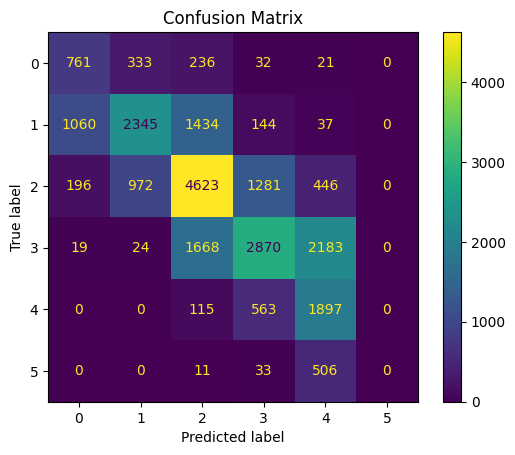

In [ ]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [ ]:
wandb.finish()

CV/qwk_score,▁
eval/eval_epoch_f0,▁
eval/eval_epoch_f0_g0,▁█
eval/eval_epoch_f0_g1,▁█
eval/eval_epoch_f0_g2,▁█
eval/eval_epoch_f1,▁
eval/eval_epoch_f1_g0,▁█
eval/eval_epoch_f1_g1,▁█
eval/eval_epoch_f1_g2,▁█
eval/eval_epoch_f2,▁
eval/eval_epoch_f2_g0,▁█
